## Core

In [ ]:
#jupyter-nbclassic --NotebookApp.disable_extension='*' --ServerApp.autoreload=True  --ServerApp.open_browser=False --Application.log_level=0 --ServerApp.log_level=0 --NotebookApp.dev_mode=True --NotebookApp.ignore_minified_js=True

In [ ]:
#| default_exp core

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from dotenv import load_dotenv
import os

In [ ]:
#| hide
load_dotenv();

In [ ]:
#| exporti
import json
from typing import List, Dict, Tuple
import textwrap
from claudette import Client
from claudette import mk_msg
from IPython import get_ipython
from IPython.display import display, clear_output, Markdown, Javascript

In [ ]:
#| export

# A single cell can contain multiple messages.
# A message is either a user message (starts with %fr) or a bot message (starts with #).
# Both can be multiline.
def parse_cell(
    cell: str # The raw body of the cell
) -> Tuple[List[Dict[str, str]], int]:
    """
    A single cell can contain multiple messages.
    A message is either a user message (starts with %fr) or a bot message (starts with #).
    Both can be multiline.

    Returns: a list of messages (with 'role' and 'content') and the number of %fr magics in the cell
    """
    parsed_lines = []
    num_magic = 0
    for line in cell.split('\n'):
        if line.startswith('%fr'):
            message = {'role': 'user', 'content': line[3:].strip()}
            num_magic += 1
        elif line.strip().startswith('#'):
            message = {'role': 'assistant', 'content': line[1:].strip()}
        else: continue

        if not parsed_lines or parsed_lines[-1]['role'] != message['role']:
            parsed_lines.append(message)
        else:
            parsed_lines[-1]['content'] += ("\n" + message['content'])

    return parsed_lines, num_magic

In [ ]:
#| exporti
#| hide

models = [
    'claude-3-opus-20240229',
    'claude-3-5-sonnet-20240620',
    'claude-3-haiku-20240307',
]
chat_client = Client(model=models[1])

magic_count = 0
messages = []

In [ ]:
# chat_client(["Hello there"])

In [ ]:
#| export
def fr_line(line: str):
    """The magic function for the %fr magic command."""
    global magic_count, messages
    ip = get_ipython()
    # raw_cell = ip.history_manager.input_hist_raw[-1]
    raw_cell = ip.get_parent()["content"]["code"]

    # The cell might have multiple %lm magics, but we only want to process the last one.
    # Presumably, the previous ones would have been processed already.
    if magic_count <= 0:
        messages, magic_count = parse_cell(raw_cell)

    print(messages)
    # This is the last %lm magic invocation of the cell.
    # But we ignore cells that don't have a user message as the last message.
    if magic_count == 1 and len(messages) > 0 and messages[-1]['role'] == 'user' and messages[-1]['content'].strip():
        reply = ""
        display_id = display(Markdown("🚀..."), display_id=True)
        try:
            r = chat_client([m['content'] for m in messages], stream=True)
            for token in r:
                reply += token
                display_id.update(Markdown(reply))

            if reply:
                reply = textwrap.fill(text=reply, width=100, initial_indent="# ", subsequent_indent="# ")
                raw_cell += f"\n{reply}\n\n%fr"
                ip.set_next_input(raw_cell, replace=True)

            clear_output()

        except BaseException as e:
            display_id.update(Markdown(f"🚫 {repr(e)}"))


    magic_count -= 1

## Friend**LL**y

In [ ]:
#| eval: False
ip = get_ipython()
ip.register_magic_function(fr_line, 'line', magic_name='fr')

In [ ]:
%fr Hello there! My name is Alex.

# Hello Alex! It's nice to meet you. I'm an AI assistant created by Anthropic to be helpful,
# harmless, and honest. How can I help you today?

%fr

[{'role': 'user', 'content': 'Hello there! My name is Alex.'}, {'role': 'assistant', 'content': "Hello Alex! It's nice to meet you. I'm an AI assistant created by Anthropic to be helpful,\nharmless, and honest. How can I help you today?"}, {'role': 'user', 'content': ''}]
[{'role': 'user', 'content': 'Hello there! My name is Alex.'}, {'role': 'assistant', 'content': "Hello Alex! It's nice to meet you. I'm an AI assistant created by Anthropic to be helpful,\nharmless, and honest. How can I help you today?"}, {'role': 'user', 'content': ''}]


In [ ]:
#| export

def load_ipython_extension(ipython):
    ipython.register_magic_function(fr_line, 'line', magic_name='fr')

def unload_ipython_extension(ipython):
    pass

In [ ]:
#| export

from time import sleep

def inject_js(js:str):
    """Inject some javascript into the notebook and clear the output to prevent it from running on reload"""
    display(Javascript(js))
    # wait=True seems to be crucial here. Without it, if I run all cells, jupyter
    # still uses the original CodeCell.execute(), which is weird, because I see the
    # injected js code executed immediately.
    clear_output(wait=True)
#     clear_output()

In [ ]:
#| export

def patch_kernel():
    payload = """
    Jupyter.CodeCell.prototype.execute = function (stop_on_error) {
        if (!this.kernel) {
            console.log(i18n.msg._("Can't execute cell since kernel is not set."));
            return;
        }

        if (stop_on_error === undefined) {
            if (this.metadata !== undefined &&
                    this.metadata.tags !== undefined) {
                if (this.metadata.tags.indexOf('raises-exception') !== -1) {
                    stop_on_error = false;
                } else {
                    stop_on_error = true;
                }
            } else {
               stop_on_error = true;
            }
        }

        this.clear_output(false, true);
        var old_msg_id = this.last_msg_id;
        if (old_msg_id) {
            this.kernel.clear_callbacks_for_msg(old_msg_id);
            delete Jupyter.CodeCell.msg_cells[old_msg_id];
            this.last_msg_id = null;
        }
        if (this.get_text().trim().length === 0) {
            // nothing to do
            this.set_input_prompt(null);
            return;
        }
        this.set_input_prompt('*');
        this.element.addClass("running");
        var callbacks = this.get_callbacks();


        const cell_index = Jupyter.notebook.find_cell_index(this)
        const cell_id = this.id
        let extras = {
            cell_index :cell_index,
            current_id: cell_id
        }
        if (this.get_text().trim().startsWith("##fr")) {
            extras = {
                all_cells: Jupyter.notebook.get_cells(),
                ...extras
            }
        }

        this.last_msg_id = this.kernel.execute(
            this.get_text(),
            callbacks,
            {silent: false, store_history: true, stop_on_error : stop_on_error, ...extras });
        Jupyter.CodeCell.msg_cells[this.last_msg_id] = this;
        this.render();
        this.events.trigger('execute.CodeCell', {cell: this});
        var that = this;
        function handleFinished(evt, data) {
            if (that.kernel.id === data.kernel.id && that.last_msg_id === data.msg_id) {
                    that.events.trigger('finished_execute.CodeCell', {cell: that});
                that.events.off('finished_iopub.Kernel', handleFinished);
              }
        }
        this.events.on('finished_iopub.Kernel', handleFinished);
    };
    Jupyter.notebook.events.trigger('set_dirty.Notebook', {value: true});

    """
    inject_js(payload)

patch_kernel()

<IPython.core.display.Javascript object>

In [ ]:
#| export
def add_cell(
        idx:int = None, # Index of the cell to add. If none, add the cell under the selected one.
        cell_type:str = "code" # Type of cell to add. Can be "code", "markdown", "raw"
    ):
    """
    Add a new notebook cell.
    """
    if not idx:
        index_payload = "let index = Jupyter.notebook.get_selected_index()+1;"
    else:
        index_payload = f"let index = {idx}"

    payload = f"""
    {index_payload}

    //console.log("add cell start, ncell=", Jupyter.notebook.ncells())
    Jupyter.notebook.insert_cell_at_index("{cell_type}", index)
    //Jupyter.notebook.insert_cell_below();
    //Jupyter.notebook.events.trigger('set_dirty.Notebook', {{value: true}});
    let cell = Jupyter.notebook.get_cell(index);
    //cell.set_text(`add_cell(${{index + 1}})\\nexecute_cell(${{index+1}})`)
    cell.events.trigger('set_dirty.Notebook', {{value: true}});
    //console.log("add cell end ncell=", Jupyter.notebook.ncells())
    """

    inject_js(payload)

In [ ]:
#| export
def update_cell(
    idx:int, # Index of the cell to update. None to update the current cell
    text:str, # Text to set in the cell
    flush:bool = True # Notify Jupyter that the cell has been updated.
    ):

    def escape_for_js(text):
        # Use json.dumps to escape the string for JavaScript
        escaped = json.dumps(text)
        # Remove the surrounding quotes added by json.dumps
        escaped = escaped[1:-1]
        # Escape backticks and ${} sequences
        return escaped.replace('`', '\\`').replace('${', '\\${')

    payload = f"""
    let cell = Jupyter.notebook.get_cell({idx})
    cell.set_text(`{escape_for_js(text)}`)
    //cell.events.trigger('set_dirty.Notebook', {{value: true}});
    """
#     print(payload)
    if flush:
         patyload = payload + "\nJupyter.notebook.events.trigger('set_dirty.Notebook', {{value: true}});"
    inject_js(payload)

In [ ]:
#| export

def execute_cell(
        idx:int # Index of the cell to execute. They start at 0
    ):
    payload = f"""
    console.log("execute_cell", {idx});
    Jupyter.notebook.events.trigger('set_dirty.Notebook', {{value: true}});
    let cell = Jupyter.notebook.get_cell({idx})
    cell.execute()
    //Jupyter.notebook.execute_cell_range({idx, idx+1})
    //Jupyter.notebook.events.trigger('set_dirty.Notebook', {{value: true}});
    """
    # tt = display(f"About to run the cell {idx}...", display_id=True)
    inject_js(payload)

In [ ]:
#| export
def render_cell(
    idx:int # Cell to render.
    ):
    """Render a markdown cell"""
    payload = f"""
    let cell = Jupyter.notebook.get_cell({idx})
    cell.unrender()
    Jupyter.notebook.events.trigger('set_dirty.Notebook', {{value: true}});

    cell.render()

    """

    inject_js(payload)


In [ ]:
#| export

from io import StringIO
import sys

class TeeIO:
    """
    OutStream that and also passes it to the original stream.
    """
    def __init__(self, stream):
        self._io = StringIO()
        self._stream = stream
        self._call_log = []

    def write(self, s):
        self._io.write(s)
        return self._stream.write(s)

    def getvalue(self):
        return self._io.getvalue()
           
    # ipykernel's OutStream class defined some other things, pass them to the parent.
    def __getattr__(self, name):
        if name in ['_stream', '_io', '_call_log']:
            # This will call object.__getattr__ on self, returning the real self.value
            return super().__getattr__(name)
        self._call_log.append(("getattr", name))
        return getattr(self._stream, name)

    def __setattr__(self, name, value):
        if name in ['_stream', '_io', '_call_log']:
            super().__setattr__(name, value)
        else:
            self._call_log.append(("setattr", name, value))
            setattr(self._stdout, name, value)

In [ ]:
#| export
from friendlly.display import PassthroughCapturer

In [ ]:
#| export
class ExecCBs:
    stdout = None
    stderr = None
    result = None # The thing at the end of the cell
    display =None
    saved_streams = None
    
    def __init__(self, once=True, after_run=None):
        self.do_after_run = after_run
        self.once = once
    
    def pre_callback(self, info=None):
        print("# pre")
        
        # This will capture diplay() and friends
        self.display = PassthroughCapturer()
        self.display.start()

        # This will capture stdout/stderr
        sys.stdout = self.stdout = TeeIO(sys.stdout)
        sys.stderr = self.stderr = TeeIO(sys.stderr)

        # We register the callback here, so it does not run after the cell
        # that registered the pre
        ip = get_ipython()
        ip.events.register("post_run_cell", self.post_callback)        
        # We get the result in the post callback info, no need to register anything else.

    def post_callback(self, result):
        # Post will be called in the cell that registers the
        # callbacks, but it wuld not have ran pre.
        print("# post")
        self.result = result
        
        if self.stdout:
            sys.stdout = self.stdout._stream
            sys.stderr = self.stderr._stream

        if self.display:
            self.display.stop()
            
        if self.once:
            self.unregister()
            
        if self.do_after_run:
            self.do_after_run(
                self.stdout.getvalue(),
                self.stderr.getvalue(),
                self.display.get_outputs(),
                result
            )
            
    def register(self):
        ip = get_ipython()
        ip.events.register("pre_run_cell", self.pre_callback)


    def unregister(self):
        try:
            ip.events.unregister("pre_run_cell", self.pre_callback)
            ip.events.unregister("post_run_cell", self.post_callback)
        except: pass # In case unregister was aclled before a cell ran, and we never regisstered pre.
            

# cbs = ExecCBs()
# cbs.register()

In [ ]:
#| export
sp="""
You are an ai research assistant. Your reply will be rendered as markdown cells.
You have access to a Jupyter notebook environment with python 3.10+ and many packages installed.
Use <code> to add a new code cell. The cell will be executed after </code>, which will end your message.
The last value placed on the cell output and anythong displayed will be provided in the user message on the next iteration.
You can use display, update or plt.show(), but don't use them if the cell is expected to produce a single result.
For example:
Calculate square root of pi:
<code>
import math
math.sqrt(math.pi)
</code>
Display cat.jpg:
<code>
from PIL import Image
Image.open("cat.jpg")
</code>
Write consise, compressed code in the style of Jeremy Howard. Don't add extra newlines before the code cell.
Use advanced python features when appropriate.
All necessary packages are already installed.
"""


In [ ]:
#| export

in_the_loop = True

def get_index():
    return ip.parent_header["content"].get("cell_index", -1)

class CellChat():
    history = list()
    def __init__(self, sp=None):
        if sp is not None: self.sp = sp
    
    def _update_markdown(self, idx, text):
        update_cell(idx, text)
        render_cell(idx)

    def _update_code(self, idx, code):
        update_cell(idx, code)
        
    def go(self, idx, user_messages, autorun=True):
        assert idx >= 0
        print(user_messages)
        self.history.append(user_messages)
        md_idx = idx+1
        code_idx = md_idx+1
        tokens = []
        try:
            md_reply = ""
            code_reply = None
            r = chat_client(self.history, sp=self.sp, stream=True, stop="</code>")
            add_cell(md_idx, "markdown")
            for token in r:
                tokens.append(token)
                if code_reply is not None:
                    code_reply += token
                    self._update_code(code_idx, code_reply)
                else:
                    md_reply += token
                    if "<code>" in md_reply:
                        md_reply, code_reply = md_reply.split("<code>")
                        add_cell(code_idx, "code")
                    self._update_markdown(md_idx, md_reply)
            if code_reply is not None:
                assert chat_client.stop_reason == "stop_sequence"
                tokens += chat_client.stop_sequence
                
                # This schedules the cell for execution once this one is finished.
                if autorun: execute_cell(code_idx)
#             self.history.append(mk_msg()"".join(tokens), )
            
            if autorun and code_reply is not None: return True
        except BaseException as e:
            display(Markdown(f"🚫 {repr(e)}"))

        
#         display("".join(tokens))
#         display(md_reply)
#         display(code_reply)
            

chat = None
cbs = None


# def after_run(stdout, stderr, display, result):
#     response = ""
    
#     if stdout: response += f"<stdout>{stdout}</stdout>
#     if stderr: response += f"<stderr>{stderr}</stderr>"
    
    
#     if result.result:
#         response += f"<result>{result.result}</result>"

def fr_cell(line=None, cell=None):  
    global cbs
    global chat
    chat = CellChat(sp)
    to_exec = chat.go(get_index(), cell)
#     if to_exec:
#         cbs = ExecCBs()
#         cbs.register()

# class FrCell():
#     def __call__(self, )
# chat.exec_cbs.register()

ip = get_ipython()
ip.register_magic_function(fr_cell, 'cell', magic_name='fr')


# FriendLLy AI overlords

In [ ]:
%%fr
Download an image of a cat and show it

<IPython.core.display.Javascript object>

Certainly! I'll use the `requests` library to download an image of a cat from a public API and then display it using PIL (Python Imaging Library). Here's the code to accomplish that:



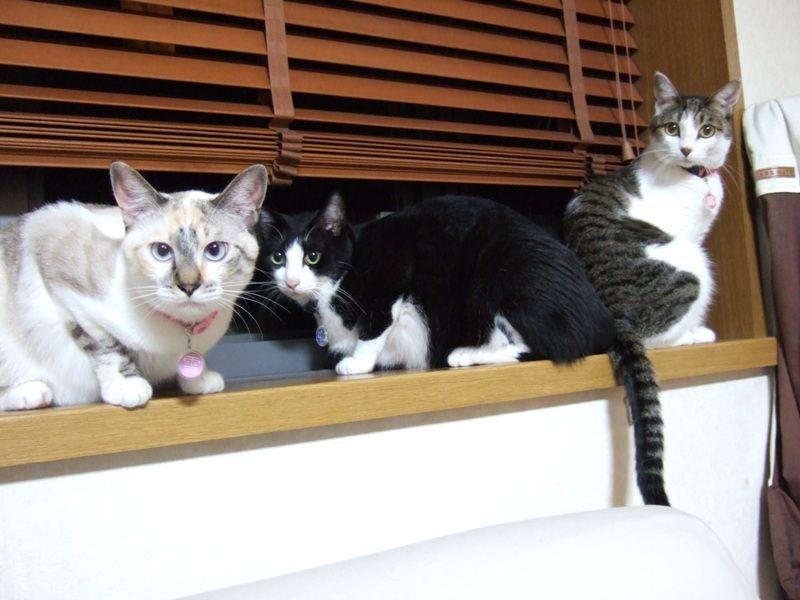

In [ ]:

import requests
from PIL import Image
from io import BytesIO

# Download a random cat image from The Cat API
url = "https://api.thecatapi.com/v1/images/search"
response = json.loads(requests.get(url).text)
img_url = response[0]['url']

# Fetch the image and display it
img = Image.open(BytesIO(requests.get(img_url).content))
img


Certainly! I'll use the `requests` library to download an image of a cat from a public API and then display it using PIL (Python Imaging Library). Here's the code to accomplish that:



In [ ]:
chat.history

['Download an image of a cat and show it \n',
 'Download an image of a cat and show it\n']

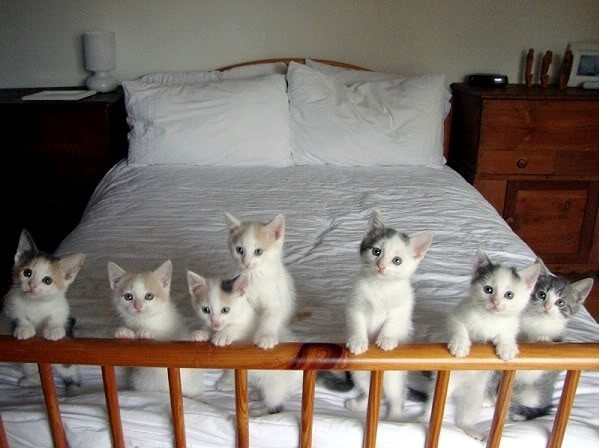

In [ ]:

import requests
from PIL import Image
from io import BytesIO

# Download a random cat image from The Cat API
url = "https://api.thecatapi.com/v1/images/search"
response = json.loads(requests.get(url).text)
img_url = response[0]['url']

# Download and display the image
img = Image.open(BytesIO(requests.get(img_url).content))
img


Certainly! Let's download an image of a cat using the `requests` library and display it using `PIL`. Here's a concise way to do this:



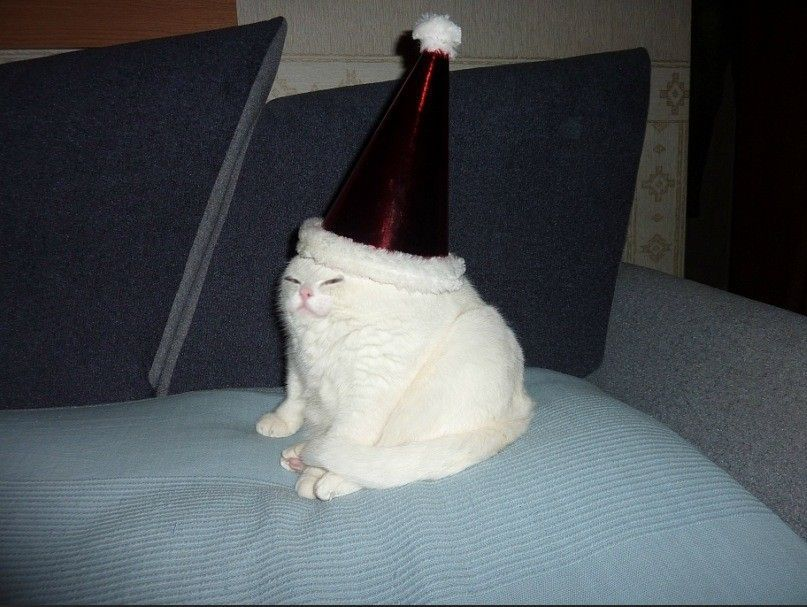

In [ ]:

import requests
from PIL import Image
from io import BytesIO

url = "https://cataas.com/cat"
response = requests.get(url)
Image.open(BytesIO(response.content))


Certainly! I'll use the `requests` library to download an image of a cat from a public API and then display it using PIL (Python Imaging Library). Here's the code to accomplish that:

